In [1]:
from loader.mnist import MNIST, MNIST_NORMALIZATION
from loader.oe_mnist import OE_MNIST_train
from loader.emnist import EMNIST
from loader.fmnist import FashionMNIST
from core.cnn import simple_cnn
from core.maha import maha_distance
from torchvision import datasets,transforms
import torch
import numpy as np
from core.score import plot, plot_confidence_hist, histogram_binning_calibrator
import matplotlib.pyplot as plt

In [2]:
tf = transforms.Compose([
            transforms.ToTensor(),
            MNIST_NORMALIZATION,
        ])
train_data = OE_MNIST_train('./dataset/',transform=tf,num=100)
test_id = MNIST('./dataset/', download=True,transform=tf,train=False)
val_id = MNIST('./dataset/', download=True,transform=tf,train=True,val=True)
test_near_ood = EMNIST('./dataset/',download=True,transform=tf,train=False,split='letters')
test_far_ood = FashionMNIST('./dataset/',download=True,transform=tf,train=False)

train_loader = torch.utils.data.DataLoader(train_data,batch_size = 128,shuffle=True)
val_id_loader = torch.utils.data.DataLoader(val_id,batch_size = 128,shuffle=False)
test_id_loader = torch.utils.data.DataLoader(test_id,batch_size = 128,shuffle=False)
test_near_ood_loader = torch.utils.data.DataLoader(test_near_ood,batch_size = 128,shuffle=False)
test_far_ood_loader = torch.utils.data.DataLoader(test_far_ood,batch_size = 128,shuffle=False)

In [3]:
model = simple_cnn(y_dim = 10).to('cuda:0')
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-4)


## Training

In [12]:
T = 10
m_in = -10
m_out = 20
def energy(logits):
    return -T*torch.log(torch.sum(torch.exp(logits)/T,dim=-1))

def cross_entropy(out,target):
    loss = torch.sum(-target*torch.log(out+1e-6),dim=-1)
    if loss.shape[0] == 0:
        return 0
    return loss.mean()

def oe_criterion(out, target):
    sout = torch.softmax(out,dim=-1)
    oe = (target == -1)
    id_ =~ oe 
    trg = target[id_]
    trg = torch.eye(10)[trg].to('cuda')
    loss_c = cross_entropy(sout[id_], trg)
    in_en = energy(out[id_])
    in_en_loss = (in_en-m_in).clip(0,None).mean()
    od_en = energy(out[oe])
    od_en_loss = (m_out - od_en).clip(0,None)
    if od_en_loss.shape[0]>0:
        od_en_loss = od_en_loss.mean()
    else:
        od_en_loss = 0
    loss = loss_c + 0.2* (in_en_loss + od_en_loss)
    return loss


In [13]:
for e in range(5):
    for image,label in train_loader:
        out = model(image.to('cuda'))
        # print(out.shape,label)
        loss = oe_criterion(out,label.to('cuda'))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss)

tensor(0.5023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4612, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1715, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)


### Test Accuracy

In [14]:
model.eval()
y_true = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_id_loader:
        out = model(image.to('cuda'))
        _,pred_logit = torch.max(out,dim=-1)
        y_true += (label==pred_logit.cpu()).numpy().tolist()
        num_acc += (label == pred_logit.cpu()).sum().item()
        total += label.shape[0]
print("Accuracy:{}".format(num_acc/total))

Accuracy:0.9766


### Uncertainty

In [17]:
model.eval()
id_score = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_id_loader:
        out = model(image.to('cuda'))
        en = energy(out)
        id_score += en.cpu().numpy().tolist()
id_score = np.asarray(id_score)
print(id_score.mean())

near_ood_score = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_near_ood_loader:
        out = model(image.to('cuda'))
        en = energy(out)
        near_ood_score += en.cpu().numpy().tolist()
near_ood_score = np.asarray(near_ood_score)
print(near_ood_score.mean())

far_ood_score = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_far_ood_loader:
        out = model(image.to('cuda'))
        en = energy(out)
        far_ood_score += en.cpu().numpy().tolist()
far_ood_score = np.asarray(far_ood_score)
print(far_ood_score.mean())

-76.34042537004947
-14.038751332226697
41.55651743967389


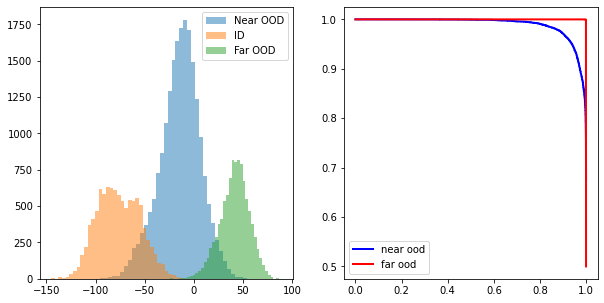

Near AUROC:0.9782605288461539, Far AUROC: 0.99999533


In [18]:
auroc = plot(id_score,near_ood_score,far_ood_score,name='Energy Based',reverse=False)
print("Near AUROC:{}, Far AUROC: {}".format(auroc[0],auroc[1]))

### Calibration

In [20]:
model.eval()
val_y_true,val_score = [], []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in val_id_loader:
        out = model(image.to('cuda'))
        en = energy(out)
        _,pred_logit = torch.max(out,dim=-1)
        val_score += en.cpu().numpy().tolist()
        val_y_true += (label==pred_logit.cpu()).numpy().tolist()
        num_acc += (label == pred_logit.cpu()).sum().item()
        total += label.shape[0]
print("Accuracy:{}".format(num_acc/total))
val_score = np.asarray(val_score)

Accuracy:0.9793333333333333


ECE(%):  0.453535191620144


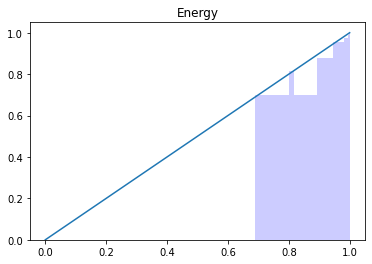

In [23]:
cval_score_en = val_score*-1
cid_score_en = id_score* -1
min_en= cval_score_en.min() -1 
max_en = cval_score_en.max() +1
cal = histogram_binning_calibrator(15,min_en, max_en)
cal.fit(cval_score_en,val_y_true)
prob_pred, prob_true, ece = cal.inference(cid_score_en, y_true)

plot_confidence_hist(prob_true,prob_pred,'Energy')